# Predicting Measured Tree Height Using LiDAR Derived Canopy Height Model
## By: Alejandro Rojas
## Gtech731_Geocomp1

### Data from the National Ecological Observatory Network (NEON) 2013 (both field data and cleaned LiDAR data)
#### Adapted from earthdatascience.org

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

# Change directory to current working folder
os.chdir('/Users/alexrojas/Documents/CUNY/Fall19/Gtech732_Geocomp1/Gtech731_Rojas_Final/')

# First, extract pixel values from AOI (in this case, each field plot where trees were measured), and calculate the mean or max height value for all pixels
## Next, compare mean or max height value derived from lidar derived canopy height model (CHM) pixels to height values from field samples
### 1. Import canopy height model to extract tree height data
### 2. Clean the data (remove values of zero for areas where there are no trees, etc.)

# -----------------------------------------------------------------

# 1. Importing Canopy height model, visualizing, and displaying summary statistics

In [2]:
## Import canopy height model created by NEON ##
# CHM = DSM - DEM

from PIL import Image
src_lidar_file = './data/SJER_lidarCHM.tif'
pil_lidar = Image.open(src_lidar_file)
lidar_array =np.array(pil_lidar)

# ## Earthpy rasterio process for getting lidar metadata and masking ZERO values
with rio.open(src_lidar_file) as sjer_lidar_chm_src:
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True) # Masked = true looks for common null values (-9999, Null, NA, etc.)
    sjer_chm_meta = sjer_lidar_chm_src.profile
print(SJER_chm_data)
print(SJER_chm_data.shape)

## Mask null values from the lidar array (Null values are -9999)
lidar_array_masked = ma.masked_values (lidar_array, -9999.)
print(lidar_array_masked)
print(lidar_array_masked.shape)

[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [8.119999885559082 9.1899995803833 10.039999961853027 ... 0.0 0.0 0.0]
 [8.09000015258789 8.510000228881836 9.300000190734863 ... 0.0 0.0 0.0]
 [7.669999599456787 7.949999809265137 8.269999504089355 ... 0.0 0.0 0.0]]
(5059, 4296)
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [8.119999885559082 9.1899995803833 10.039999961853027 ... 0.0 0.0 0.0]
 [8.09000015258789 8.510000228881836 9.300000190734863 ... 0.0 0.0 0.0]
 [7.669999599456787 7.949999809265137 8.269999504089355 ... 0.0 0.0 0.0]]
(5059, 4296)


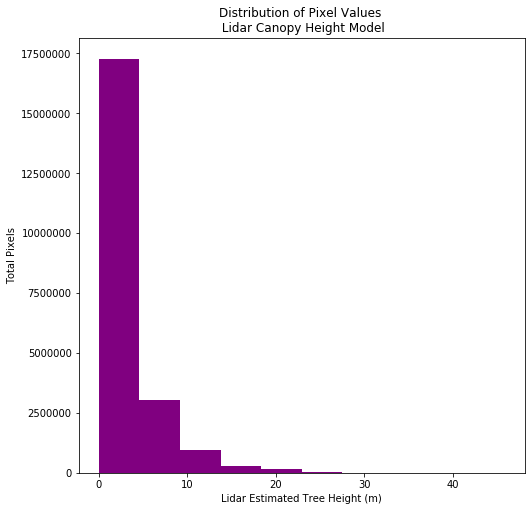

In [3]:
## Plot histogram of lidar estimated tree height
## Method 1
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(lidar_array_masked.ravel(),
        color="purple")
ax.set(xlabel="Lidar Estimated Tree Height (m)",
       ylabel="Total Pixels",
       title="Distribution of Pixel Values \n Lidar Canopy Height Model")
# Turn off scientific notation
ax.ticklabel_format(useOffset=False,
                    style='plain')

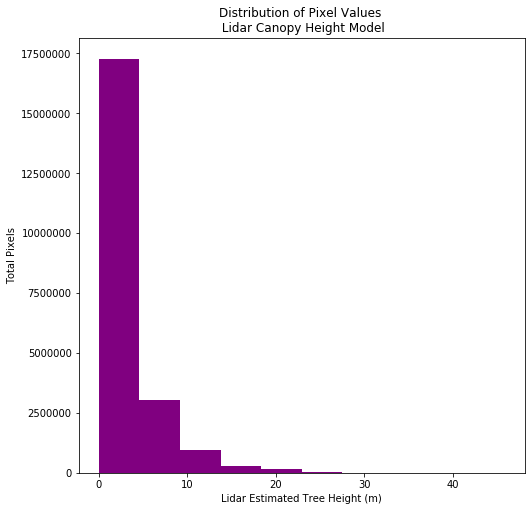

In [5]:
## Plot histogram of lidar estimated tree height
## Method 2
fig = plt.figure(figsize=(8, 8))
lidar_plot = plt.hist(lidar_array_masked.ravel(),
        color="purple")
plt.title('Distribution of Pixel Values \n Lidar Canopy Height Model')
plt.ylabel('Total Pixels')
plt.xlabel('Lidar Estimated Tree Height (m)')
plt.ticklabel_format(useOffset=False,
                    style='plain')

In [6]:
# View summary statistics of canopy height model
print('Mean:', lidar_array_masked.mean())
print('Max:', lidar_array_masked.max())
print('Min:', lidar_array_masked.min())

Mean: 1.935586243204776
Max: 45.879997
Min: 0.0


# 2. Cleaning and organizing data (remove zeroes)

In [10]:
# Set all pixel values of 0 to NAN (no data or not a number)
lidar_array_masked[lidar_array_masked == 0] = np.nan

# View summary statistics of canopy height model
print('Mean:', np.nanmean(lidar_array_masked))
print('Max:', np.nanmax(lidar_array_masked))
print('Min:', np.nanmin(lidar_array_masked))

Mean: 8.213505
Max: 45.879997
Min: 2.0


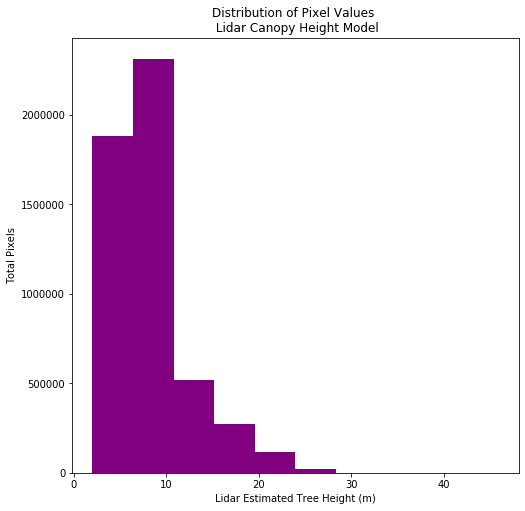

In [11]:
## Histogram of data with zeroes removed ##
# Remove nans, flatten the data, and plot the histogram

lidar_array_no_na = lidar_array_masked[~np.isnan(lidar_array_masked)]

## Plot histogram of lidar estimated tree height with zeroes removed
fig = plt.figure(figsize=(8, 8))
lidar_plot = plt.hist(lidar_array_no_na.ravel(),
        color="purple")
plt.title('Distribution of Pixel Values \n Lidar Canopy Height Model')
plt.ylabel('Total Pixels')
plt.xlabel('Lidar Estimated Tree Height (m)')
plt.ticklabel_format(useOffset=False,
                    style='plain')

In [12]:
## Import plot location data and create buffer
## Compare the maximum measured tree height value to the maximum
## LiDAR derived height value for each circular plot using regression analysis

# Import plot centroid locations using geopandas
centroids_path = './data/SJER_plot_centroids.shp'
plot_centroids = gpd.read_file(centroids_path)

# Examine first five points in the shapefile
plot_centroids.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.76 4110819.876)
3,SJER117,center,4108752.026,256176.947,trees,POINT (256176.947 4108752.026)
4,SJER120,center,4110476.079,255968.372,grass,POINT (255968.372 4110476.079)


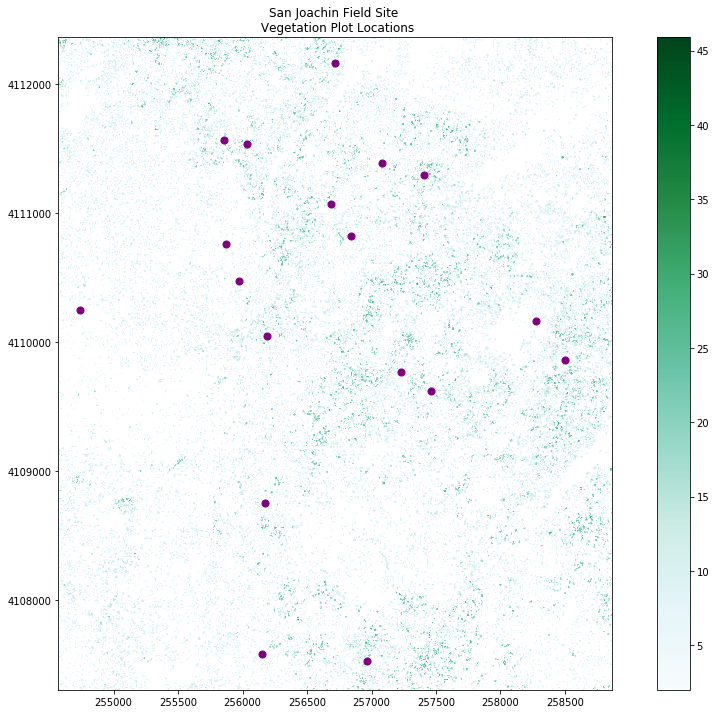

In [13]:
## Overlay points on top of raster data ##

fig, ax = plt.subplots(figsize=(16, 12))
lidar_plot = ax.imshow(lidar_array_masked, cmap='BuGn', extent=plotting_extent(sjer_lidar_chm_src))
ax.set_title('San Joachin Field Site \n Vegetation Plot Locations')
fig.colorbar(lidar_plot, ax=ax)

plot_centroids.plot(ax=ax, markersize=50, color='purple')

plt.show()

In [14]:
## Create a buffer around each plot location to extract tree height values from LIDAR data

# Create a buffered polygon layer from plot location points
plots_poly = plot_centroids.copy() # must make a copy to preserve original data

# Buffer each point using a 20 meter circle radius and replace the point geometry with the new buffered geometry
plots_poly["geometry"] = plot_centroids.geometry.buffer(20)
plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.27969..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.87069..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.76 4110819.876, 256858.663694..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.85069..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.27569..."


In [15]:
# Export buffered plot points layer as a new shapefile
# This layer will be used for zonal statistics

# If directory does not exist, create a new one
if not os.path.isdir('./outputs'):
    os.mkdir('./outputs')

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = './outputs/plot_buffer.shp'
plots_poly.to_file(plot_buffer_path)

In [18]:
## Extract pixel values

# Rasterstats contains a zonalstatistics function that will be used to
# extract raster values within buffered plots centroids
import rasterstats as rs

# Extract zonal stats into a list
plot_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   lidar_array_masked,
                                   nodata=-9999,
                                   affine=sjer_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# View object type
type(plot_tree_heights)
print(plot_tree_heights)


[{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('Plot_ID', 'SJER1068'), ('Point', 'center'), ('northing', 4111567.818), ('easting', 255852.376), ('plot_type', 'trees'), ('min', 2.0399999618530273), ('max', 19.049999237060547), ('mean', 11.544347580915652), ('count', 161), ('median', 12.619999885559082)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(255872.376, 4111567.818), (255872.27969453344, 4111565.857657193), (255871.99170560806, 4111563.9161935598), (255871.51480671464, 4111562.012306455), (255870.85359065022, 4111560.164331353), (255870.01442528696, 4111558.3900652635), (255869.00539224604, 4111556.7065953393), (255867.83620906723, 4111555.1301343166), (255866.51813562372, 4111553.675864376), (255865.06386568327, 4111552.3577909325), (255863.48740466038, 4111551.1886077537), (255861.8039347365, 4111550.179574713), (255860.0296686473, 4111549.3404093497), (255858.18169354508, 4111548.6791932853), (255856.2778064403, 4111548.202294392), (255854.33634280658, 41115

In [19]:
# Convert list to geopandas dataframe to plot data
lidar_plot_height_df = gpd.GeoDataFrame.from_features(plot_tree_heights)
lidar_plot_height_df.head()

,Plot_ID,Point,count,easting,geometry,max,mean,median,min,northing,plot_type
0,SJER1068,center,161,255852.376,"POLYGON ((255872.376 4111567.818, 255872.27969...",19.049999,11.544348,12.62,2.04,4111567.818,trees
1,SJER112,center,443,257406.967,"POLYGON ((257426.967 4111298.971, 257426.87069...",24.019999,10.369277,7.87,2.10,4111298.971,trees
2,SJER116,center,643,256838.760,"POLYGON ((256858.76 4110819.876, 256858.663694...",16.070000,7.518398,6.80,2.82,4110819.876,grass
3,SJER117,center,245,256176.947,"POLYGON ((256196.947 4108752.026, 256196.85069...",11.059999,7.675347,7.93,3.24,4108752.026,trees
4,SJER120,center,17,255968.372,"POLYGON ((255988.372 4110476.079, 255988.27569...",5.740000,4.591176,4.45,3.38,4110476.079,grass


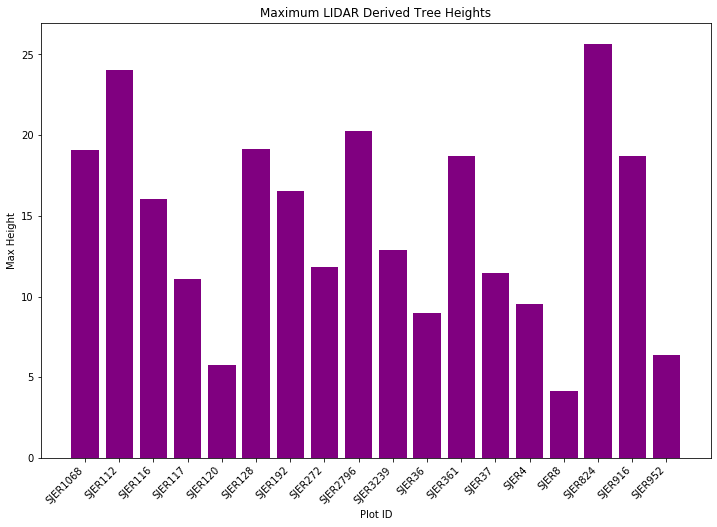

In [20]:
# Create a bar plot of the max lidar derived height by plot site
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(lidar_plot_height_df['Plot_ID'],
      lidar_plot_height_df['max'],
      color='purple')
ax.set(xlabel='Plot ID', ylabel='Max Height',
       title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

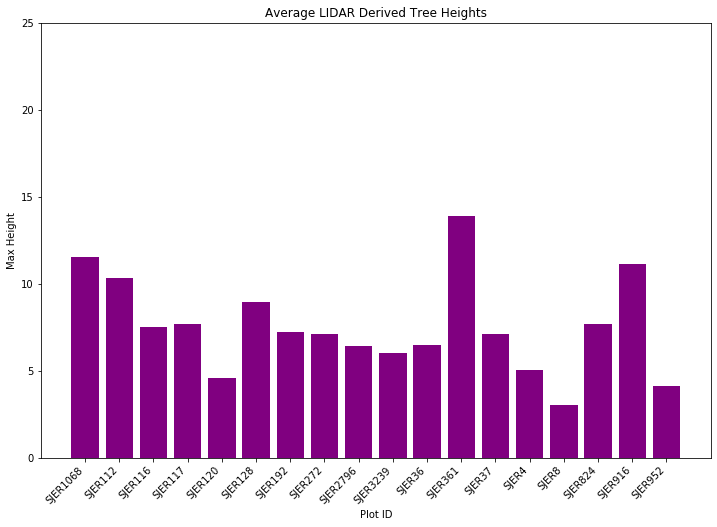

In [21]:
# Create a bar plot of the average lidar derived height by plot site

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(lidar_plot_height_df['Plot_ID'],
      lidar_plot_height_df['mean'],
      color='purple',)
ax.set(xlabel='Plot ID', ylabel='Max Height',
       title='Average LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim((0,25))


plt.show()

# Comparing tree height field data with LiDAR derived CHM data for each plot
## 1. Get summary statistics from field data, measured within circular plots across the study area

In [22]:
# Import & view insitu (field measured) data using pandas
path_field_data = './data/D17_2013_SJER_vegStr.csv'
field_data_all = pd.read_csv(path_field_data)

# View columns in data
field_data_all.columns

Index(['siteid', 'sitename', 'plotid', 'easting', 'northing', 'taxonid',
       'scientificname', 'indvidual_id', 'pointid', 'individualdistance',
       'individualazimuth', 'dbh', 'dbhheight', 'basalcanopydiam',
       'basalcanopydiam_90deg', 'maxcanopydiam', 'canopydiam_90deg',
       'stemheight', 'stemremarks', 'stemstatus', 'canopyform', 'livingcanopy',
       'inplotcanopy', 'materialsampleid', 'dbhqf', 'stemmapqf', 'plant_group',
       'common_name', 'aop_plot', 'unique_id'],
      dtype='object')

In [23]:
# Select only columns that will be needed in the analysis
field_data_clean = field_data_all[[
    "siteid", "sitename", "plotid", "stemheight", "scientificname"]]
field_data_clean.head()

,siteid,sitename,plotid,stemheight,scientificname
0,SJER,San Joaquin,SJER128,18.2,Pinus sabiniana
1,SJER,San Joaquin,SJER2796,3.3,Arctostaphylos viscida
2,SJER,San Joaquin,SJER272,1.7,Arctostaphylos viscida
3,SJER,San Joaquin,SJER112,2.1,Arctostaphylos viscida
4,SJER,San Joaquin,SJER272,3.0,Arctostaphylos viscida


In [24]:
## Summarize tree height data

# First, group data by the plot_id column
# Next, use the agg() function to get summary statistics (mean and max) from the stemheight column

field_data_stem_ht = field_data_clean.groupby('plotid').agg(
    ['mean', 'max'])['stemheight']
field_data_stem_ht.head()

,mean,max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [25]:
# Rename columns so we know which is insitu data and which are lidar data (since we are joining tables)

field_data_stem_ht.columns = ['insitu_' + col for col in field_data_stem_ht.columns]

# Reset the plot id to the original id to use as unique ID when joining tables
field_data_stem_ht = field_data_stem_ht.reset_index()
field_data_stem_ht.head()

,plotid,insitu_mean,insitu_max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


In [26]:
# Rename columns so that we know which columns represent lidar values
lidar_plot_height_df = lidar_plot_height_df.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean', 'median': 'lidar_median', 'min': 'lidar_min'})

# Join lidar and human measured tree height data
final_height_df = lidar_plot_height_df.merge(field_data_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')
final_height_df.head()

,Plot_ID,Point,count,easting,geometry,lidar_max,lidar_mean,lidar_median,lidar_min,northing,plot_type,plotid,insitu_mean,insitu_max
0,SJER1068,center,161,255852.376,"POLYGON ((255872.376 4111567.818, 255872.27969...",19.049999,11.544348,12.62,2.04,4111567.818,trees,SJER1068,3.866667,19.3
1,SJER112,center,443,257406.967,"POLYGON ((257426.967 4111298.971, 257426.87069...",24.019999,10.369277,7.87,2.10,4111298.971,trees,SJER112,8.221429,23.9
2,SJER116,center,643,256838.760,"POLYGON ((256858.76 4110819.876, 256858.663694...",16.070000,7.518398,6.80,2.82,4110819.876,grass,SJER116,8.218750,16.0
3,SJER117,center,245,256176.947,"POLYGON ((256196.947 4108752.026, 256196.85069...",11.059999,7.675347,7.93,3.24,4108752.026,trees,SJER117,6.512500,11.0
4,SJER120,center,17,255968.372,"POLYGON ((255988.372 4110476.079, 255988.27569...",5.740000,4.591176,4.45,3.38,4110476.079,grass,SJER120,7.600000,8.8


# Plot CHM and field data

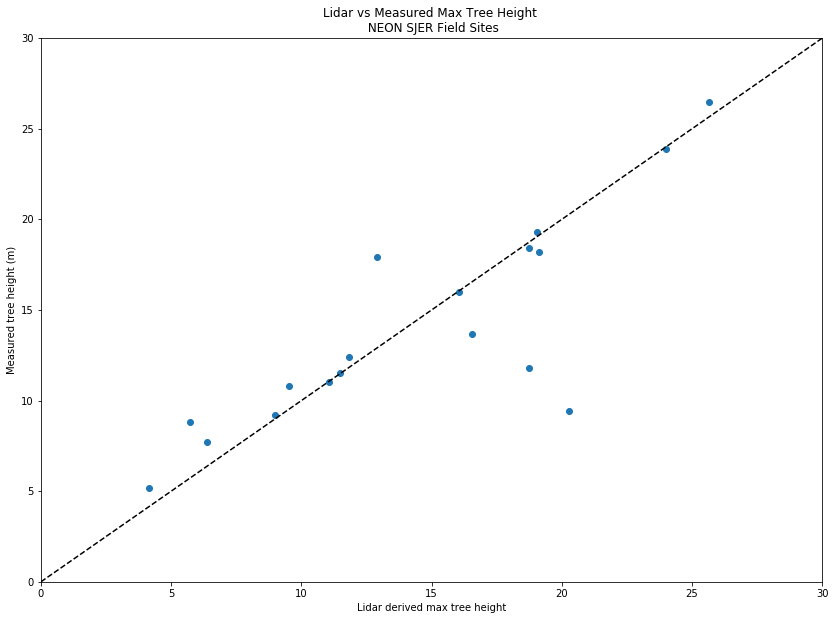

In [27]:
## Plot the CHM vs field data by field site
fig = plt.figure(figsize=(14,10))
scatter_plot = plt.scatter(final_height_df['lidar_max'], final_height_df['insitu_max'])
plt.title('Lidar vs Measured Max Tree Height \n NEON SJER Field Sites')
plt.ylabel('Measured tree height (m)')
plt.xlabel('Lidar derived max tree height')
plt.xlim((0, 30))
plt.ylim((0, 30))

# Create a reference line with a 1:1 relationship
line_x = list(range(0,100,1))
line_y = line_x
plt.plot(line_x, line_y, ls='--', c='k')

# Regression Analysis

## 1. Predicting max tree height values

In [79]:
## Get coefficients for regression predicting max tree height

# x (independent variable) corresponds to lidar_maxht_vector
# y (dependent variable) corresponds to measured_maxht_vector

# First, extract a vector matrix of the max values to use in regression
measured_maxht_vector = final_height_df['insitu_max'].values
lidar_maxht_vector = final_height_df['lidar_max'].values

# Create a function to calculte coefficients b0 and b1
def calc_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation of x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1)

b_0, b_1 = calc_coef(lidar_maxht_vector, measured_maxht_vector)
print('Intercept (b0): \n', b_0, '\n Slope for first coefficient (b1): \n', b_1)

Intercept (b0): 
 2.981466474434452 
 Slope for first coefficient (b1): 
 0.7607314439776314


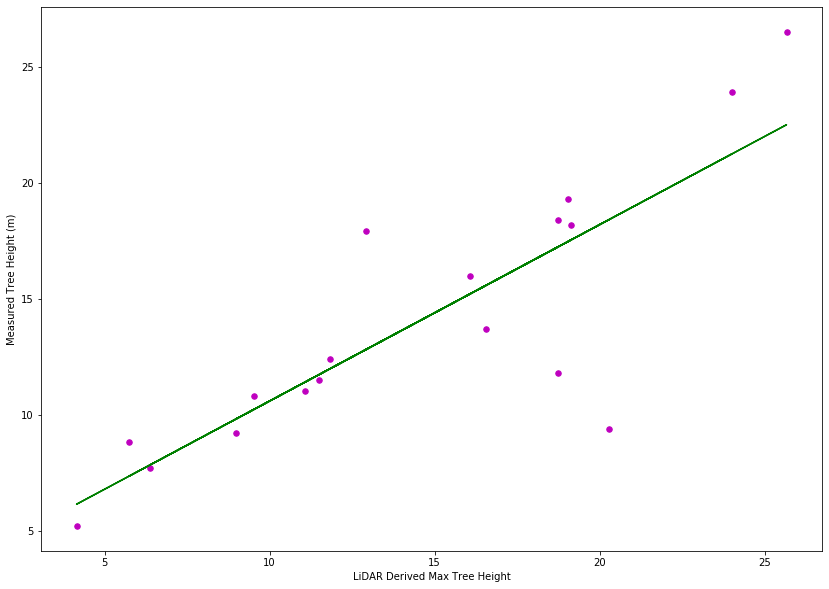

In [37]:
# set up figure size
plt.figure(figsize=(14,10))

# plotting the actual points as scatter plot 
plt.scatter(lidar_maxht_vector, measured_maxht_vector, color = "m", marker = "o", s = 30) 
  
# predicted response vector 
y_pred_max = b_0 + b_1*lidar_maxht_vector
  
# plotting the regression line 
plt.plot(lidar_maxht_vector, y_pred_max, color = "g") 
  
# add labels 
plt.xlabel('LiDAR Derived Max Tree Height') 
plt.ylabel('Measured Tree Height (m)') 
  
# function to show plot 
plt.show()

In [95]:
diff_sq_max = (measured_maxht_vector - y_pred_max)**2
se_max = (sum(diff_sq_max))/len(diff_sq_max)
print('Measured Max Tree Height = 2.98 + 0.76*(LiDAR_CHM)')
print('Standard error of regression for predicting max values: ', se)

Measured Max Tree Height = 2.98 + 0.76*(LiDAR_CHM)
Standard error of regression for predicting max values:  5.026921646742202


In [104]:
## Calculate the coefficient of determination, r2

# First, calculte the pearson's correlation (r)

total_sum_differences = 0
for x, y in zip(lidar_maxht_vector, measured_maxht_vector):
    xdiff = (x - lidar_maxht_vector.mean())
    ydiff = (y - measured_maxht_vector.mean())
    xy_multiplied = xdiff * ydiff
    total_sum_differences += xy_multiplied
r = (total_sum_differences)/((len(lidar_maxht_vector)-1)*(lidar_maxht_vector.std())* measured_maxht_vector.std())

r2 = r*r
print('r2 = ', r2)

r2 =  0.7747469744371898


## 2. Predicting average tree height values

In [80]:
## Get coefficients for regression predicting average tree height

# x (independent variable) corresponds to lidar_maxht_vector
# y (dependent variable) corresponds to measured_maxht_vector

# First, extract a vector matrix of the max values to use in regression
measured_mean_vector = final_height_df['insitu_mean'].values
lidar_mean_vector = final_height_df['lidar_mean'].values

# Create a function to calculte coefficients b0 and b1
def calc_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation of x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1)

b_0, b_1 = calc_coef(lidar_mean_vector, measured_mean_vector)
print('Intercept (b0): \n', b_0, '\n Slope for first coefficient (b1): \n', b_1)

Intercept (b0): 
 5.26306573502462 
 Slope for first coefficient (b1): 
 0.04533157661520601


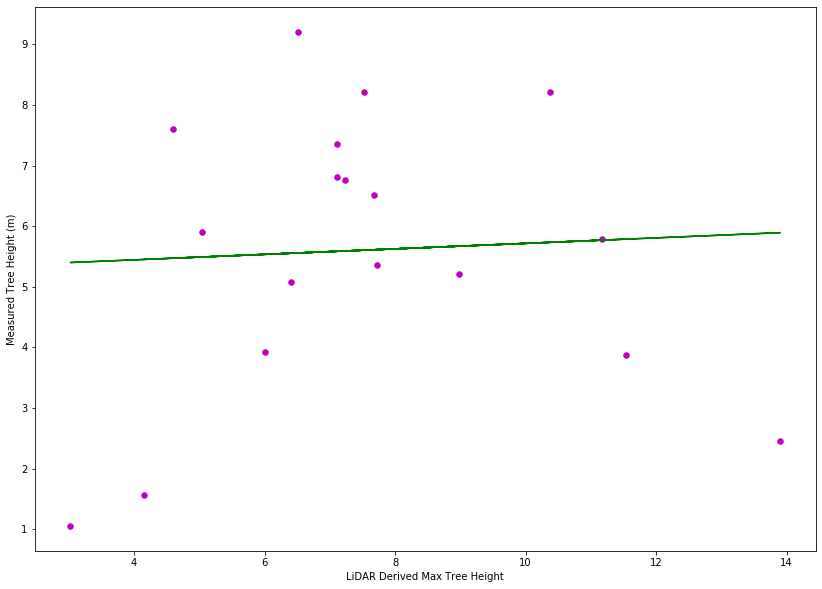

In [40]:
# set up figure size
plt.figure(figsize=(14,10))

# plotting the actual points as scatter plot 
plt.scatter(lidar_mean_vector, measured_mean_vector, color = "m", marker = "o", s = 30) 
  
# predicted response vector 
y_pred_mean = b_0 + b_1*lidar_mean_vector
  
# plotting the regression line 
plt.plot(lidar_mean_vector, y_pred_mean, color = "g") 
  
# add labels 
plt.xlabel('LiDAR Derived Max Tree Height') 
plt.ylabel('Measured Tree Height (m)') 
  
# function to show plot 
plt.show()

In [101]:
diff_sq = (measured_mean_vector - y_pred_mean)**2
se = (sum(diff_sq))/len(diff_sq)
print('Measured Average Tree Height = 5.26 + 0.04*(LiDAR_CHM)')
print('Standard error of regression for predicting mean values: ', se)

Measured Average Tree Height = 5.26 + 0.04*(LiDAR_CHM)
Standard error of regression for predicting mean values:  5.026921646742202


In [103]:
## Calculate the coefficient of determination, r2

# First, calculte the pearson's correlation (r)

total_sum_differences = 0
for x, y in zip(lidar_mean_vector, measured_mean_vector):
    xdiff = (x - lidar_mean_vector.mean())
    ydiff = (y - measured_mean_vector.mean())
    xy_multiplied = xdiff * ydiff
    total_sum_differences += xy_multiplied
r = (total_sum_differences)/((len(lidar_mean_vector)-1)*(lidar_mean_vector.std())* measured_mean_vector.std())
r2_mean_values = r*r
print('r2 = ', r2_mean_values)

r2 =  0.003345643238319492
